# LangGraph 101: Building Multi-Agent

In this notebook, we're going to walk through setting up a **multi-agent workflow** in LangGraph. We will start from a simple ReAct agent and add additional steps into the workflow, simulating a realistic customer support example, showcasing human-in-the-loop, long term memory, and the LangGraph pre-built library. 

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), and is able to handle customer inqueries related to invoice and music. 

![Arch](../images/architecture.png) 



For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!


## Pre-work: Setup

#### Loading environment variables

To start, let's load our environment variables from our .env file. Make sure all of the keys necessary in .env.example are included!

In [1]:
from dotenv import load_dotenv
from langchain_aws import ChatBedrockConverse
import os

load_dotenv(dotenv_path="../.env", override=True)

AWS_ACCESS_KEY_ID=os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY=os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION_NAME=os.getenv("AWS_REGION_NAME")

model = ChatBedrockConverse(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    region_name=AWS_REGION_NAME,
    provider="anthropic",
    model_id="arn:aws:bedrock:us-west-2:640174622193:inference-profile/us.anthropic.claude-sonnet-4-20250514-v1:0"
)

#### Loading sample customer data

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains sample information on customer information, purchase history, and music catalog. 

In [2]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

#### Setting up short-term and long-term memory 

We will also initialize a checkpointer for **short-term memory**, maintaining context within a single thread. 

**Long term memory** lets you store and recall information between conversations. Today, we will utilize our long term memory store to store user preferences for personalization. 



In [3]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

## Part 1: Building ReAct Sub-Agents

### 1.1 Building a ReAct Agent from Scratch

Now that we are set up, we are ready to build out our **first subagent**. This is a simple ReAct agent that fetches information related to music store catalog, utilizing a set of tools to generate its response. 

![react_1](../images/music_subagent.png)

#### State

How does information flow through the steps?  

State is the first LangGraph concept we'll cover. **State can be thought of as the memory of the agent - its a shared data structure that’s passed on between the nodes of your graph**, representing the current snapshot of your application. 

For this our customer support agent our state will track the following elements: 
1. The customer ID
2. Conversation history
3. Memory from long term memory store
4. Remaining steps, which tracks # steps until it hits recursion limit

In [4]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    customer_id: str
    messages: Annotated[list[AnyMessage], add_messages]
    loaded_memory: str
    remaining_steps: RemainingSteps 

#### Tools
Let's define a list of **tools** our agent will have access to. Tools are functionts that can act as extension of the LLM's capabilities. In our case, we will create several tools that interacts with the Chinook database regarding music. 

We can create tools using the @tool decorator to create a tool

In [5]:
from langchain_core.tools import tool
import ast

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    genre_ids = ast.literal_eval(genre_ids)
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    if not songs:
        return f"No songs found for the genre: {genre}"
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]
llm_with_music_tools = model.bind_tools(music_tools)

#### Nodes

Now that we have a list of tools, we are ready to build nodes that interact with them. 

Nodes are just python (or JS/TS!) functions. Nodes take in your graph's State as input, execute some logic, and return a new State. 

Here, we're just going to set up 2 nodes for our ReAct agent:
1. **music_assistant**: Reasoning node that decides which function to invoke 
2. **music_tools**: Node that contains all the available tools and executes the function

LangGraph has a pre-built ToolNode that we can utilize to create a node for our tools. 

In [6]:
from langgraph.prebuilt import ToolNode
# Node
music_tool_node = ToolNode(music_tools)

In [7]:
from langchain_core.messages import ToolMessage, AIMessage, HumanMessage
from langchain_core.runnables import RunnableConfig

# Music assistant prompt
def generate_music_assistant_prompt(memory: str = "None") -> str:
    return f"""
    You are a member of the assistant team, your role specifically is to focused on helping customers discover and learn about music in our digital catalog. 
    If you are unable to find playlists, songs, or albums associated with an artist, it is okay. 
    Just inform the customer that the catalog does not have any playlists, songs, or albums associated with that artist.
    You also have context on any saved user preferences, helping you to tailor your response. 
    
    CORE RESPONSIBILITIES:
    - Search and provide accurate information about songs, albums, artists, and playlists
    - Offer relevant recommendations based on customer interests
    - Handle music-related queries with attention to detail
    - Help customers discover new music they might enjoy
    - You are routed only when there are questions related to music catalog; ignore other questions. 
    
    SEARCH GUIDELINES:
    1. Always perform thorough searches before concluding something is unavailable
    2. If exact matches aren't found, try:
       - Checking for alternative spellings
       - Looking for similar artist names
       - Searching by partial matches
       - Checking different versions/remixes
    3. When providing song lists:
       - Include the artist name with each song
       - Mention the album when relevant
       - Note if it's part of any playlists
       - Indicate if there are multiple versions
    
    Additional context is provided below: 

    Prior saved user preferences: {memory}
    
    Message history is also attached.  
    """

# Node 
def music_assistant(state: State, config: RunnableConfig): 

    # Fetching long term memory. 
    memory = "None" 
    if "loaded_memory" in state: 
        memory = state["loaded_memory"]

    # Intructions for our agent  
    music_assistant_prompt = generate_music_assistant_prompt(memory)

    # Invoke the model
    response = llm_with_music_tools.invoke([AIMessage(music_assistant_prompt)] + state["messages"])
    
    # Update the state
    return {"messages": [response]}

#### Edges

Now, we need to define a control flow that connects between our defined nodes, and that's where the concept of edges come in.

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, we want a **conditional edge** from our subagent that determines whether to: 
- Invoke tools, or,
- Route to the end if user query has been finished 

In [8]:
# Conditional edge that determines whether to continue or not
def should_continue(state: State, config: RunnableConfig):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

#### Compile Graph!

Now that we've defined our State and Nodes, let's put it all together and construct our react agent!

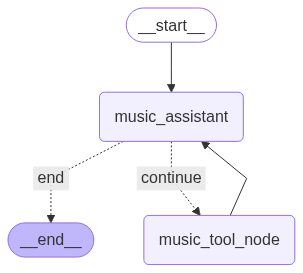

In [9]:
from langgraph.graph import StateGraph, START, END

music_workflow = StateGraph(State)

# Add nodes 
music_workflow.add_node("music_assistant", music_assistant)
music_workflow.add_node("music_tool_node", music_tool_node)


# Add edges 
# First, we define the start node. The query will always route to the subagent node first. 
music_workflow.add_edge(START, "music_assistant")

# We now add a conditional edge
music_workflow.add_conditional_edges(
    "music_assistant",
    # Function representing our conditional edge
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "music_tool_node",
        # Otherwise we finish.
        "end": END,
    },
)

music_workflow.add_edge("music_tool_node", "music_assistant")

music_catalog_subagent = music_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store = in_memory_store)

music_catalog_subagent

#### Testing

Let's see how it works!

In [10]:
import uuid
thread_id = uuid.uuid4()

question = "I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?"
config = {"configurable": {"thread_id": thread_id}}

result = music_catalog_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

for message in result["messages"]:
   message.pretty_print()

================================ Human Message =================================

I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?
================================== Ai Message ==================================

[{'type': 'text', 'text': "I'd be happy to help you discover some great music! Let me search for Rolling Stones songs and albums in our catalog first, and then I can suggest some similar artists you might enjoy."}, {'type': 'tool_use', 'name': 'get_tracks_by_artist', 'input': {'artist': 'Rolling Stones'}, 'id': 'tooluse_2BMnAydcRaKXPYnaJ1n6gA'}, {'type': 'tool_use', 'name': 'get_albums_by_artist', 'input': {'artist': 'Rolling Stones'}, 'id': 'tooluse_HMt2IEjjR0KFBZjI76JkEg'}]
Tool Calls:
  get_tracks_by_artist (tooluse_2BMnAydcRaKXPYnaJ1n6gA)
 Call ID: tooluse_2BMnAydcRaKXPYnaJ1n6gA
  Args:
    artist: Rolling Stones
  get_albums_by_artist (tooluse_HMt2IEjjR0KFBZjI76JkEg)
 Call ID: tooluse_HMt2IEjjR0KFBZjI76JkEg
  Args:
    

### 1.2. Building ReAct Agent using LangGraph Pre-built

LangGraph offers pre-built libraries for common architectures, allowing us to quickly create architectures like ReAct or multi-agent architacture. A full list of pre-built libraries can be found here: https://langchain-ai.github.io/langgraph/prebuilt/#available-libraries 

In the last workflow, we have seen how we can build a ReAct agent from scratch. Now, we will show how we can leverage the LangGraph pre-built libraries to achieve similar results. 

![react_2](../images/invoice_subagent.png)

Our **invoice info subagent** is responsible for all customer queries related to the invoices. 

#### Defining tools and prompt
Similarly, let's first define a set of tools and our agent prompt below. 

In [11]:
from langchain_core.tools import tool

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)


@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info

invoice_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer]

In [12]:
invoice_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized for retrieving and processing invoice information. You are routed for invoice-related portion of the questions, so only respond to them.. 

    You have access to three tools. These tools enable you to retrieve and process invoice information from the database. Here are the tools:
    - get_invoices_by_customer_sorted_by_date: This tool retrieves all invoices for a customer, sorted by invoice date.
    - get_invoices_sorted_by_unit_price: This tool retrieves all invoices for a customer, sorted by unit price.
    - get_employee_by_invoice_and_customer: This tool retrieves the employee information associated with an invoice and a customer.
    
    If you are unable to retrieve the invoice information, inform the customer you are unable to retrieve the information, and ask if they would like to search for something else.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information about invoices, including customer details, invoice dates, total amounts, employees associated with the invoice, etc. when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional context that you should use to help answer the customer's query. It will be provided to you below:
    """

#### Using the pre-built library
Now, let's put them together by using the pre-built ReAct agent library

In [13]:
from langgraph.prebuilt import create_react_agent

# Define the subagent 
invoice_information_subagent = create_react_agent(model, tools=invoice_tools, name="invoice_information_subagent",prompt=invoice_subagent_prompt, state_schema=State, checkpointer=checkpointer, store=in_memory_store)

#### Testing!
Let's try our new agent out!

In [14]:
thread_id = uuid.uuid4()
question = "My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?"
config = {"configurable": {"thread_id": thread_id}}

result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_subagent

[{'type': 'text', 'text': "I'll help you find your most recent invoice and the employee who assisted you. Let me retrieve your invoice information first."}, {'type': 'tool_use', 'name': 'get_invoices_by_customer_sorted_by_date', 'input': {'customer_id': '1'}, 'id': 'tooluse_9XvexaetSaKrA_i-FDHI9w'}]
Tool Calls:
  get_invoices_by_customer_sorted_by_date (tooluse_9XvexaetSaKrA_i-FDHI9w)
 Call ID: tooluse_9XvexaetSaKrA_i-FDHI9w
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: get_invoices_by_customer_sorted_by_date

[(382, 1, '2025-08-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-

## Part 2: Building multi-agent architecture

Now that we have two sub-agents that have different capabilities. How do we make sure customer tasks are appropriately routed between them? 

This is where the supervisor oversees the workflow, invoking appropriate subagents for relevant inquiries. 


A **multi-agent architecture** offers several key benefits:
- Specialization & Modularity – Each sub-agent is optimized for a specific task, improving system accuracy 
- Flexibility – Agents can be quickly added, removed, or modified without affecting the entire system

![supervisor](../images/supervisor.png)

We will show how we can utilize the pre-built supervisor to quickly create the multi-agent architecture. 

First, we will create a set of instructions for our supervisor. 

In [15]:
supervisor_prompt = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 

Your team is composed of two subagents that you can use to help answer the customer's request:
1. music_catalog_information_subagent: this subagent has access to user's saved music preferences. It can also retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database. 
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. 

Based on the existing steps that have been taken in the messages, your role is to generate the next subagent that needs to be called. 
This could be one step in an inquiry that needs multiple sub-agent calls. """

Adding a function to clean the messages list to work with Bedrock's validation

In [16]:
def clean_messages(state):
    """
    A helper to clean messages that have no content - Anthropic specific logic
    """
    messages: list[AnyMessage] = state.get("messages", [])
    updated_messages = []
    
    for msg in messages:        
        if not msg.content:
            updated_messages.append(msg.model_copy(update={"content": "(no content)"}))
            updated_messages[-1].content = updated_messages[-1].content.strip()
    
    return {"messages": updated_messages}

Build the supervisor and display the graph!

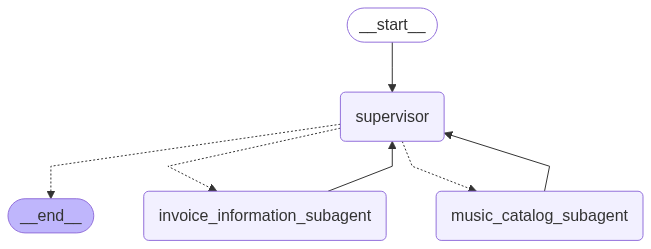

In [17]:
from langgraph_supervisor import create_supervisor

# Create supervisor workflow
supervisor_prebuilt_workflow = create_supervisor(
    agents=[invoice_information_subagent, music_catalog_subagent],
    output_mode="full_history", 
    model=model,
    prompt=(supervisor_prompt), 
    state_schema=State,
    #post_model_hook=clean_messages
)

supervisor_prebuilt = supervisor_prebuilt_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store=in_memory_store)
supervisor_prebuilt

Let's test it out!

In [18]:
thread_id = uuid.uuid4()
question = "My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor_prebuilt.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?
================================== Ai Message ==================================
Name: supervisor

[{'type': 'text', 'text': "I'll help you with both of your questions. Let me get the information about your most recent purchase and check what U2 albums we have in our catalog."}, {'type': 'tool_use', 'name': 'transfer_to_invoice_information_subagent', 'input': {}, 'id': 'tooluse_YDuH7Y_WTA-MdOqwVFE7_g'}]
Tool Calls:
  transfer_to_invoice_information_subagent (tooluse_YDuH7Y_WTA-MdOqwVFE7_g)
 Call ID: tooluse_YDuH7Y_WTA-MdOqwVFE7_g
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_inf

## Part 3: Adding customer verification through human-in-the-loop

We currently invoke our graph with a customer ID as the customer identifier, but realistically, we may not always have access to the customer identity. To solve this, we want to **first verify the customer information** before executing their inquiry with our supervisor agent. 

In this step, we will be showing a simple implementation of such a node, using **human-in-the-loop** to prompt the customer to provide their account information. 

![customer-input](../images/human_input.png)

In this step, we will write two nodes: 
- **verify_info** node that verifies account information 
- **human_input** node that prompts user to provide additional information 

ChatModels support attaching a structured data schema to adhere response to. This is useful in scenarios like extracting information or categorizing. 

In [19]:
from pydantic import BaseModel, Field

class UserInput(BaseModel):
    """Schema for parsing user-provided account information."""
    identifier: str = Field(description = "Identifier, which can be a customer ID, email, or phone number.")

structured_llm = model.with_structured_output(schema=UserInput)
structured_system_prompt = """You are a customer service representative responsible for extracting customer identifier.\n 
Only extract the customer's account information from the message history. 
If they haven't provided the information yet, return an empty string for the file"""

In [20]:
from typing import Optional 

# Helper 
def get_customer_id_from_identifier(identifier: str) -> Optional[int]:
    """
    Retrieve Customer ID using an identifier, which can be a customer ID, email, or phone number.
    
    Args:
        identifier (str): The identifier can be customer ID, email, or phone.
    
    Returns:
        Optional[int]: The CustomerId if found, otherwise None.
    """
    if identifier.isdigit():
        return int(identifier)
    elif identifier[0] == "+":
        query = f"SELECT CustomerId FROM Customer WHERE Phone = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0]
    elif "@" in identifier:
        query = f"SELECT CustomerId FROM Customer WHERE Email = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0]
    return None 

In [21]:
# Node

def verify_info(state: State, config: RunnableConfig):
    """Verify the customer's account by parsing their input and matching it with the database."""

    if state.get("customer_id") is None: 
        system_instructions = """You are a music store agent, where you are trying to verify the customer identity 
        as the first step of the customer support process. 
        Only after their account is verified, you would be able to support them on resolving the issue. 
        In order to verify their identity, one of their customer ID, email, or phone number needs to be provided.
        If the customer has not provided their identifier, please ask them for it.
        If they have provided the identifier but cannot be found, please ask them to revise it."""

        user_input = state["messages"][-1] 
    
        # Parse for customer ID
        parsed_info = structured_llm.invoke([AIMessage(content=structured_system_prompt)] + [user_input])
    
        # Extract details
        identifier = parsed_info.identifier
    
        customer_id = None
        # Attempt to find the customer ID
        if (identifier):
            customer_id = get_customer_id_from_identifier(identifier)
    
        if customer_id is not None:
            intent_message = AIMessage(
                content= f"Thank you for providing your information! I was able to verify your account with customer id {customer_id}."
            )
            return {
                  "customer_id": customer_id,
                  "messages" : [intent_message]
                  }
        else:
          response = model.invoke([AIMessage(content=system_instructions)]+state['messages'])
          return {"messages": [response]}

    else: 
        return {"messages": state["messages"]}

Now, let's create our human_input node. We will be prompting the user input through the Interrupt class. 

In [22]:
from langgraph.types import interrupt
# Node
def human_input(state: State, config: RunnableConfig):
    """ No-op node that should be interrupted on """
    user_input = interrupt("Please provide input.")
    return {"messages": [user_input]}

Let's put this together! 

In [23]:
# conditional_edge
def should_interrupt(state: State, config: RunnableConfig):
    if state.get("customer_id") is not None:
        return "continue"
    else:
        return "interrupt"

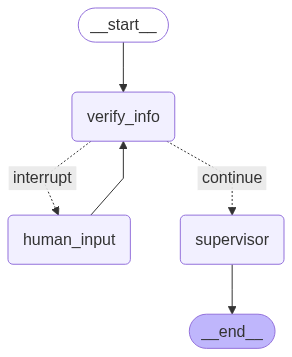

In [24]:
# Add nodes 
multi_agent_verify = StateGraph(State)
multi_agent_verify.add_node("verify_info", verify_info)
multi_agent_verify.add_node("human_input", human_input)
multi_agent_verify.add_node("supervisor", supervisor_prebuilt)

multi_agent_verify.add_edge(START, "verify_info")
multi_agent_verify.add_conditional_edges(
    "verify_info",
    should_interrupt,
    {
        "continue": "supervisor",
        "interrupt": "human_input",
    },
)
multi_agent_verify.add_edge("human_input", "verify_info")
multi_agent_verify.add_edge("supervisor", END)
multi_agent_verify_graph = multi_agent_verify.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)
multi_agent_verify_graph

Let's test it out!

In [25]:
thread_id = uuid.uuid4()
question = "How much was my most recent purchase?"
config = {"configurable": {"thread_id": thread_id}}

result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Hello! I'd be happy to help you look up information about your most recent purchase. However, I'll need to verify your identity first before I can access your account details.

Could you please provide one of the following:
- Your customer ID
- The email address associated with your account
- The phone number on your account

Once I can verify your identity, I'll be able to look up your recent purchase history for you.


In [26]:
from langgraph.types import Command

# Resume from interrupt 
question = "My phone number is +55 (12) 3923-5555."
result = multi_agent_verify_graph.invoke(Command(resume=question), config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Hello! I'd be happy to help you look up information about your most recent purchase. However, I'll need to verify your identity first before I can access your account details.

Could you please provide one of the following:
- Your customer ID
- The email address associated with your account
- The phone number on your account

Once I can verify your identity, I'll be able to look up your recent purchase history for you.
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================== Ai Message ==================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==============================

In [27]:
question = "What albums do you have by the Rolling Stones?"
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Hello! I'd be happy to help you look up information about your most recent purchase. However, I'll need to verify your identity first before I can access your account details.

Could you please provide one of the following:
- Your customer ID
- The email address associated with your account
- The phone number on your account

Once I can verify your identity, I'll be able to look up your recent purchase history for you.
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================== Ai Message ==================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==============================

Now, if I ask a follow-up question in the same thread, our agent state stores our customer_id, not needing to verify again. 

## Part 4: Adding Long-Term Memory

Now that we have created an agent workflow that includes verification and execution, let's take it a step further. 

**Long term memory** lets you store and recall information between conversations. We have already initialized a long term memory store. 


![memory](../images/memory.png)

In this step, we will add 2 nodes: 
- **load_memory** node that loads from the long term memory store
- **create_memory** node that saves any music interests that the customer has shared about themselves 

In [28]:
from langgraph.store.base import BaseStore

# helper function to structure memory 
def format_user_memory(user_data):
    """Formats music preferences from users, if available."""
    profile = user_data['memory']
    result = ""
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    return result.strip()

# Node
def load_memory(state: State, config: RunnableConfig, store: BaseStore):
    """Loads music preferences from users, if available."""
    
    user_id = state["customer_id"]
    namespace = ("memory_profile", user_id)
    existing_memory = store.get(namespace, "user_memory")
    formatted_memory = ""
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    return {"loaded_memory" : formatted_memory}

In [29]:
# User profile structure for creating memory

class UserProfile(BaseModel):
    customer_id: str = Field(
        description="The customer ID of the customer"
    )
    music_preferences: List[str] = Field(
        description="The music preferences of the customer"
    )

In [30]:
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request. 
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 

Take a deep breath and think carefully before responding."""

# Node
def create_memory(state: State, config: RunnableConfig, store: BaseStore):
    user_id = str(state["customer_id"])
    namespace = ("memory_profile", user_id)
    existing_memory = store.get(namespace, "user_memory")
    if existing_memory and existing_memory.value:
        existing_memory_dict = existing_memory.value
        formatted_memory = (
            f"Music Preferences: {', '.join(existing_memory_dict.get('music_preferences', []))}"
        )
    else:
        formatted_memory = ""
    formatted_system_message = AIMessage(content=create_memory_prompt.format(conversation=state["messages"], memory_profile=formatted_memory))
    updated_memory = model.with_structured_output(UserProfile).invoke([formatted_system_message])
    key = "user_memory"
    store.put(namespace, key, {"memory": updated_memory})

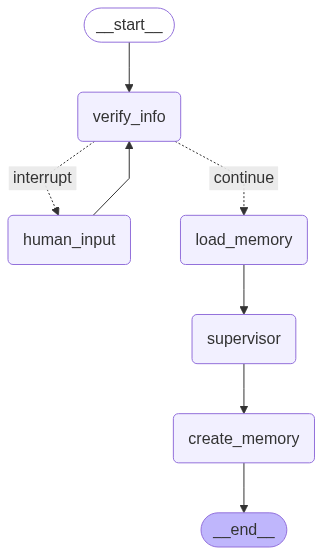

In [31]:
multi_agent_final = StateGraph(State)
multi_agent_final.add_node("verify_info", verify_info)
multi_agent_final.add_node("human_input", human_input)
multi_agent_final.add_node("load_memory", load_memory)
multi_agent_final.add_node("supervisor", supervisor_prebuilt)
multi_agent_final.add_node("create_memory", create_memory)

multi_agent_final.add_edge(START, "verify_info")
multi_agent_final.add_conditional_edges(
    "verify_info",
    should_interrupt,
    {
        "continue": "load_memory",
        "interrupt": "human_input",
    },
)
multi_agent_final.add_edge("human_input", "verify_info")
multi_agent_final.add_edge("load_memory", "supervisor")
multi_agent_final.add_edge("supervisor", "create_memory")
multi_agent_final.add_edge("create_memory", END)
multi_agent_final_graph = multi_agent_final.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)
multi_agent_final_graph

In [32]:
thread_id = uuid.uuid4()
from langchain_core.messages import HumanMessage

question = "My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?"
config = {"configurable": {"thread_id": thread_id}}

result = multi_agent_final_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?
================================== Ai Message ==================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor

[{'type': 'text', 'text': "\n\nBased on your inquiry, I'll need to help you with two requests:\n1. Finding information about your most recent purchase amount\n2. Looking up albums by the Rolling Stones in our catalog\n\nLet me start by checking your recent purchase information."}, {'type': 'tool_use', 'name': 'transfer_to_invoice_information_subagent', 'input': {}, 'id': 'tooluse_IQ3f0PzGRSqjzqOOkcdpwg'}]
Tool Calls:
  transfer_to_invoice_information_subagent (tooluse_IQ3f0PzGRSqjzqOOkcdpwg)
 Call ID: tooluse_IQ

Let's take a look at the memory!

In [33]:
user_id = "1"
namespace = ("memory_profile", user_id)
memory = in_memory_store.get(namespace, "user_memory").value

saved_music_preferences = memory.get("memory").music_preferences

print(saved_music_preferences)

['The Rolling Stones']


## Evaluations

**Evaluations** are a quantitative way to measure performance of agents, which is important beacause LLMs don't always behave predictably — small changes in prompts, models, or inputs can significantly impact results. Evaluations provide a structured way to identify failures, compare changes across different versions of your applicaiton, and build more reliable AI applications.

Evaluations are made up of three components:

1. A **dataset test** inputs and expected outputs.
2. An **application or target function** that defines what you are evaluating, taking in inputs and returning the application output
3. **Evaluators** that score your target function's outputs.

![Evaluation](../images/evals-conceptual.png) 

There are many ways you can evaluate an agent. Today, we will cover the three common types of agent evaluations:

1. **Final Response**: Evaluate the agent's final response.
2. **Single step**: Evaluate any agent step in isolation (e.g., whether it selects the appropriate tool).
3. **Trajectory**: Evaluate whether the agent took the expected path (e.g., of tool calls) to arrive at the final answer.

### Evaluating The Final Response

One way to evaluate an agent is to assess its overall performance on a task. This basically involves treating the agent as a black box and simply evaluating whether or not it gets the job done.
- Input: User input 
- Output: The agent's final response.


![final-response](../images/final-response.png) 

#### 1. Create a Dataset

In [34]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "response": "The Invoice ID of your most recent purchase was 342.",
    },
    {
        "question": "I'd like a refund.",
        "response": "I need additional information to help you with the refund. Could you please provide your customer identifier so that we can fetch your purchase history?",
    },
    {
        "question": "Who recorded Wish You Were Here again?",
        "response": "Wish You Were Here is an album by Pink Floyd",
    },
    { 
        "question": "What albums do you have by Coldplay?",
        "response": "There are no Coldplay albums available in our catalog at the moment.",
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Final Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"response": ex["response"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. Define Application Logic to be Evaluated 

Now, let's define how to run our graph. Note that here we must continue past the interrupt() by supplying a Command(resume="") to the graph.

In [35]:
import uuid
from langgraph.types import Command

graph = multi_agent_final_graph

async def run_graph(inputs: dict):
    """Run graph and track the final response."""
    # Creating configuration 
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id" : "10"}

    # Invoke graph until interrupt 
    result = await graph.ainvoke({"messages": [
        { "role": "user", "content": inputs['question']}]}, config = configuration)
    # Proceed from human-in-the-loop 
    result = await graph.ainvoke(Command(resume="My customer ID is 10"), config={"thread_id": thread_id, "user_id" : "10"})
    
    return {"response": result['messages'][-1].content}

#### 3. Define the Evaluator

We can use pre-built evaluators from the `openevals` library

In [ ]:
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

# Using Open Eval pre-built 
correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=model,
)
print(CORRECTNESS_PROMPT)

We can also define our own evaluator.

In [37]:
# Custom definition of LLM-as-judge instructions
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# LLM-as-judge output schema
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# Judge LLM
grader_llm = model.with_structured_output(Grade, method="json_schema", strict=True)

# Evaluator function
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    # Note that we assume the outputs has a 'response' dictionary. We'll need to make sure
    # that the target function we define includes this key.
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    return grade["is_correct"]

#### 4. Run the Evaluation

In [ ]:
# Evaluation job and results
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[final_answer_correct, correctness_evaluator],
    experiment_prefix="agent-o3mini-e2e",
    num_repetitions=1,
    max_concurrency=5,
)

### Evaluating a Single Step of the Agent

Agents generally perform multiple actions. While it is useful to evaluate them end-to-end, it can also be useful to evaluate these individual actions, similar to the concept of unit testing in software development. This generally involves evaluating a single step of the agent - the LLM call where it decides what to do.

- Input: Input to a single step 
- Output: Output of that step, which is usually the LLM response
![single-step](../images/single-step.png) 

#### 1. Create a Dataset for this Single Step

In [39]:

examples = [
    {
        "messages": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?", 
        "route": 'transfer_to_invoice_information_subagent'
    },
    {
        "messages": "What songs do you have by U2?", 
        "route": 'transfer_to_music_catalog_subagent'
    },
    {
        "messages": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?", 
        "route": 'transfer_to_invoice_information_subagent'
    },
    {
        "messages": "Who recorded Wish You Were Here again? What other albums by them do you have?", 
        "route": 'transfer_to_music_catalog_subagent'
    }
]


dataset_name = "LangGraph 101 Multi-Agent: Single-Step"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs = [{"messages": ex["messages"]} for ex in examples],
        outputs = [{"route": ex["route"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. Define the Application Logic to Evaluate 

We only need to evaluate the supervisor routing step, so let's add a breakpoint right after the supervisor step.

In [40]:
async def run_supervisor_routing(inputs: dict):
    result = await supervisor_prebuilt.ainvoke(
        {"messages": [HumanMessage(content=inputs['messages'])]},
        interrupt_before=["music_catalog_subagent", "invoice_information_subagent"],
        config={"thread_id": uuid.uuid4(), "user_id" : "10"}
    )
    return {"route": result["messages"][-1].name}

#### 3. Define the Evaluator

In [41]:
def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the agent chose the correct route."""
    return outputs['route'] == reference_outputs["route"]

#### 4. Run the Evaluation

In [ ]:
experiment_results = await client.aevaluate(
    run_supervisor_routing,
    data=dataset_name,
    evaluators=[correct],
    experiment_prefix="agent-o3mini-singlestep",
    max_concurrency=5,
)

### Evaluating the Trajectory of the Agent

Evaluating an agent's trajectory involves evaluating all the steps an agent took. The evaluator here is some function over the steps taken. Examples of evaluators include an exact match for each tool name in the sequence or the number of "incorrect" steps taken.

- Input: User input to the overall agent 
- Output: A list of steps taken.
![trajectory](../images/trajectory.png) 

#### 1. Create a Dataset

In [43]:
# Create a dataset
examples = [
    {
        "question": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"],
    },
    {
        "question": "What songs do you have by U2?",
        "trajectory": ["verify_info", "human_input", "human_input", "verify_info", "human_input"],
    },
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"],
    },
    {
        "question": "Who recorded Wish You Were Here again? What other albums by them do you have?",
        "trajectory": ["verify_info", "human_input", "human_input", "verify_info", "human_input"],
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Trajectory Eval"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"trajectory": ex["trajectory"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. Define the Application Logic to Evaluate 

In [44]:
graph = multi_agent_final_graph

async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = []
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id" : "10"}

    # Run until interrupt 
    async for chunk in graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, config = configuration, stream_mode="debug"):
        if chunk['type'] == 'task':
            trajectory.append(chunk['payload']['name'])

    # Resume from interrupt
    async for chunk in graph.astream(Command(resume=""), config = configuration, stream_mode="debug"):
        if chunk['type'] == 'task':
            trajectory.append(chunk['payload']['name'])
    return {"trajectory": trajectory}

#### 3. Define the Evaluator

In [45]:
def evaluate_exact_match(outputs: dict, reference_outputs: dict):
    """Evaluate whether the trajectory exactly matches the expected output"""
    return {
        "key": "exact_match", 
        "score": outputs["trajectory"] == reference_outputs["trajectory"]
    }

def evaluate_extra_steps(outputs: dict, reference_outputs: dict) -> dict:
    """Evaluate the number of unmatched steps in the agent's output."""
    i = j = 0
    unmatched_steps = 0

    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1  # Match found, move to the next step in reference trajectory
        else:
            unmatched_steps += 1  # Step is not part of the reference trajectory
        j += 1  # Always move to the next step in outputs trajectory

    # Count remaining unmatched steps in outputs beyond the comparison loop
    unmatched_steps += len(outputs['trajectory']) - j

    return {
        "key": "unmatched_steps",
        "score": unmatched_steps,
    }

#### 4. Run the Evaluation

In [ ]:
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[evaluate_extra_steps, evaluate_exact_match],
    experiment_prefix="agent-o3mini-trajectory",
    num_repetitions=1,
    max_concurrency=4,
)